# Generate qcodes parameters from a sequence

Ideal snippet

```python

seq = broadbean.Sequence()
# (...)

params = create_seq_params(seq)
saw_freq = params[0]

# Option 1: insert directly instructions {...}
seq_new = sweep_sequence(seq, instructions)

# Option 2: use sweeper
sw = Sweeper()
sw.sweep_linear(saw_freq, 1e9, 2e9, dim=1)
# (...)
seq_new = sweep_sequence(seq, sw.get_instructions())

# Set to AWG
awg = AWG(...) # Tektronix or Keysight
# (...)
awg.fill_sequence_table(seq_new)

```

In [1]:
%matplotlib widget
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import broadbean as bb
from broadbean.plotting import plotter

from qcodes import Parameter

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\manip.batm\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\manip.batm\.qcodes\logs\221124-10540-qcodes.log


# Parameter functions

In [2]:
def wf_set_cmd(elem,channel,function,arg):
    function = str(function)
    channel = int(channel)
    arg = str(arg)
    if arg == 'duration':
        def set_cmd(v):
            elem.changeDuration(channel,function,v)
    else:
        def set_cmd(v):
            elem.changeArg(channel,function,arg,v)
    return set_cmd

def wf_get_cmd(elem,channel,function,arg):
    function = str(function)
    channel = str(channel)
    arg = str(arg)
    if arg == 'duration':
        def get_cmd():
            return elem.duration  
    else:
        def get_cmd():
            ch_d = elem.description[channel]
            for seg_d in ch_d.values():
                if seg_d['name'] == function:
                    break
            return seg_d['arguments'][arg]    
    return get_cmd

def create_params_from_sequence(seq):
    param_kwargs = _param_kwargs_from_sequence(seq.description)
    params = []
    for slot_key, slot_d in param_kwargs.items():
        slot_i = int(slot_key[1:]) # format: si
        for key, bp_d in slot_d['channels'].items():
            ch = int(key[1:]) # format: ci
            for func, kws in bp_d.items():
                for kw in kws:
                    param_kws = dict(kw)
                    arg = kw['name']
                    param_kws['name'] = f'{slot_key}_ch{ch}_{func}_{arg}'

                    elem = seq.element(slot_i)
                    cmd_args = tuple([elem, ch, func, arg]) 
                    param_kws['set_cmd'] = wf_set_cmd(*cmd_args)
                    param_kws['get_cmd'] = wf_get_cmd(*cmd_args)
                    params.append(Parameter(**param_kws))
    return params

def _param_kwargs_from_sequence(seq_description):
    seq_d = dict(seq_description)
    param_kwargs = {}
    for key, slot_d in seq_d.items():
        if key == 'awgspecs':
            continue
        param_kwargs[f's{key}'] = _param_kwargs_from_sequence_slot(slot_d)
    return param_kwargs     

def _param_kwargs_from_sequence_slot(slot_description):
    slot_d = dict(slot_description)
    param_kwargs = {}
    param_kwargs[f'channels'] = _param_kwargs_from_element(slot_d['channels'])
    param_kwargs[f'sequencing'] = _param_kwargs_from_sequencing(slot_d['sequencing'])
    return param_kwargs         

def _param_kwargs_from_sequencing(sequencing_description):
    s_d = dict(sequencing_description)
    kws_list = []
    for key, value in s_d.items():
        name = str(key).lower().replace(' ','_')
        kw = dict(name=name, set_cmd=None,get_cmd=None, initial_value=value)
        kws_list.append(kw)
    return kws_list         
    
def _param_kwargs_from_element(elem_description):
    el_d = dict(elem_description)
    param_kwargs = {}
    for ch, bp_d in el_d.items():
        param_kwargs[f'c{ch}'] = _param_kwargs_from_blueprint(bp_d)
    return param_kwargs         

def _param_kwargs_from_blueprint(bp_description):
    bp_d = dict(bp_description)
    param_kwargs = {}
    seg_descriptions = [bp_d[key] for key in bp_d.keys() if 'segment' in key]
    for seg_d in seg_descriptions:
        param_kwargs.update(_param_kwargs_from_segment(seg_d))
#     marker_lists = {'m1': bp_d['marker1_abs'], 'm2': bp_d['marker1_abs']}
#     for name, m_list in marker_lists.items():
#         param_kwargs[name] = _marker_params_from_list(m_list)
    return param_kwargs

def _param_kwargs_from_segment(seg_description):
    d = dict(seg_description)
    func_name = d['name']
    if func_name in ['waituntil', 'ensureaverage_fixed_level']:
        # ignore because it cannot be changed
        return {}
    
    kws_list = []
    for arg, value in d['arguments'].items():
        kw = dict(name=arg,set_cmd=None,get_cmd=None,initial_value=value)
        kws_list.append(kw)
#     kws_list.append(dict(name='duration',set_cmd=None,get_cmd=None))
    
    return {func_name: kws_list}

# Segment functions

In [3]:
dur2pts = lambda SR, dur: int(dur*SR)

def pulse(voff, von, ti, tf, SR, npts):
    ti_idx = dur2pts(SR, ti)
    tf_idx = dur2pts(SR, tf)
    values = np.ones(npts) * voff
    values[ti_idx:tf_idx] = von
    return values    

def mysine(freq, vpp, voff, phase, ti, tf, SR, npts):
    ti_idx = dur2pts(SR, ti)
    tf_idx = dur2pts(SR, tf)
    values = np.ones(npts) * voff
    t = np.linspace(ti,tf,tf_idx-ti_idx)
    values[ti_idx:tf_idx] = np.sin(2*np.pi*freq*t + 2*np.pi*phase)*vpp + voff
    return values   

ramp = bb.PulseAtoms.ramp
sine = bb.PulseAtoms.sine

# Create BluePrint, Element (= Waveform) and Sequence

In [4]:
SR = 12 # S/s
duration = 20 # ns
channels = {'SAW': 1, 'TCW': 2}

## Element 1: cleaning SAW pulse

2022-11-24 16:42:00,144 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\manip.batm\Anaconda3\envs\qube\lib\site-packages\broadbean\plotting.py:243: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])



{'segment_01': {'name': 'mysine', 'function': 'function mysine', 'durations': 20, 'arguments': {'freq': 1, 'vpp': 1, 'voff': 0.0, 'phase': 0, 'ti': 5, 'tf': 15}}, 'marker1_abs': [], 'marker2_abs': [], 'marker1_rel': [(0, 0)], 'marker2_rel': [(0, 0)]}
Legend: Name, function, arguments, timesteps, durations
Segment 1: "mysine", mysine, (1, 1, 0.0, 0, 5, 15), 20
----------
{'segment_01': {'name': 'waituntil', 'function': 'waituntil', 'durations': None, 'arguments': {'waittime': (10.0,)}}, 'segment_02': {'name': 'pulse', 'function': 'function pulse', 'durations': 10.0, 'arguments': {'voff': 0, 'von': 0, 'ti': 1, 'tf': 3}}, 'marker1_abs': [], 'marker2_abs': [], 'marker1_rel': [(0, 0), (0, 0)], 'marker2_rel': [(0, 0), (0, 0)]}
Legend: Name, function, arguments, timesteps, durations
Segment 1: "waituntil", waituntil, (10.0,), None
Segment 2: "pulse", pulse, (0, 0, 1, 3), 10.0
----------


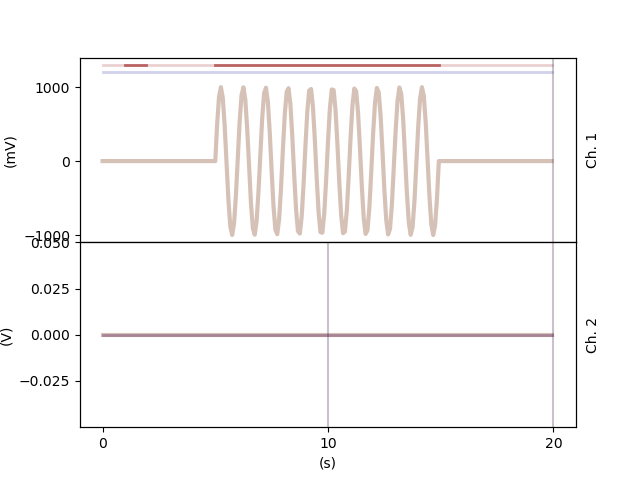

In [5]:
bp_clean = bb.BluePrint()
bp_clean.setSR(SR)
# Cleaning SAW pulse
bp_clean.insertSegment(-1, mysine, (1, 1, 0.0, 0, 5, 15), dur=duration)
print(bp_clean.description)
bp_clean.showPrint()
bp_clean.marker1 = [(1, 1), (5, 10)]
# bp_clean.marker2 = [(1, 0.2), (2.5, 0.1)]

bp_dummy = bb.BluePrint()
bp_dummy.setSR(SR)
# bp_dummy.insertSegment(-1, ramp, (0,0), dur=duration)
bp_dummy.insertSegment(-1, 'waituntil', (duration/2,))
bp_dummy.insertSegment(-1, pulse, (0, 0, 1, 3), dur=duration/2)
print(bp_dummy.description)
bp_dummy.showPrint()
# bp_dummy.marker1 = [(1, 1), (5, 10)]

elem1 = bb.Element()
elem1.addBluePrint(channels['SAW'], bp_clean)
elem1.addBluePrint(channels['TCW'], bp_dummy)
elem1.validateDurations()
plotter(elem1)

# Element 2: SAW + TCW pulse

Legend: Name, function, arguments, timesteps, durations
Segment 1: "mysine", mysine, (1, 0.5, 0.0, 0, 1, 9), 20
----------
Legend: Name, function, arguments, timesteps, durations
Segment 1: "pulse", pulse, (0, 1, 1, 3), 5
Segment 2: "slope_left", PulseAtoms.ramp, (0, 0.5), 5
Segment 3: "slope_right", PulseAtoms.ramp, (0.5, 0), 5
Segment 4: "ramp", PulseAtoms.ramp, (0, 0), 5
----------


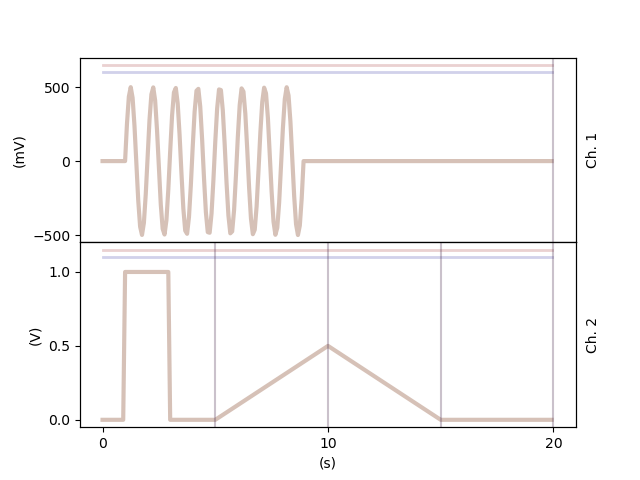

In [6]:
bp_saw = bb.BluePrint()
bp_saw.setSR(SR) 
bp_saw.insertSegment(-1, mysine, (1, 0.5, 0.0, 0, 1, 9), dur=duration)
bp_saw.showPrint()
# plotter(bp2)

bp_tcw = bb.BluePrint()
bp_tcw.setSR(SR)  
bp_tcw.insertSegment(-1, pulse, (0, 1, 1, 3), dur=5)
bp_tcw.insertSegment(-1, ramp, (0, 0.5), name='slope_left', dur=5)
bp_tcw.insertSegment(-1, ramp, (0.5, 0), name='slope_right', dur=5)
bp_tcw.insertSegment(-1, ramp, (0, 0), dur=duration - bp_tcw.duration)
bp_tcw.showPrint()
# plotter(bp1)

elem2 = bb.Element()
elem2.addBluePrint(channels['SAW'], bp_saw)
elem2.addBluePrint(channels['TCW'], bp_tcw)
elem2.validateDurations()
plotter(elem2)

# Create sequence

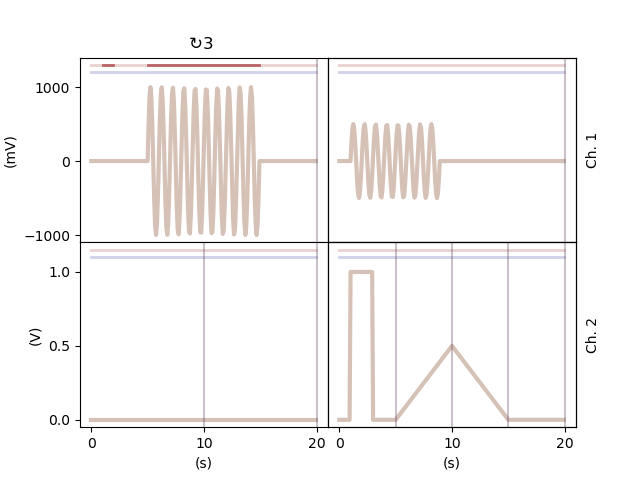

In [7]:
seq1 = bb.Sequence()
seq1.setChannelAmplitude(channels['SAW'], 1)
seq1.setChannelAmplitude(channels['TCW'], 0.5)
seq1.setChannelOffset(channels['SAW'], 0)
seq1.setChannelOffset(channels['TCW'], 0)

seq1.setSR(SR)

# Cleaning 
n_clean = 3
seq1.addElement(1, elem1)  # Call signature: seq. pos., element
seq1.setSequencingNumberOfRepetitions(1,n_clean)
# seq1.setSequencingTriggerWait(1,'test') # it works with str
# seq1.setSequencingGoto(1, 0) # 0 = next
# seq1.setSequencingEventInput(1, 0) # 0 for off, 1 for 'TrigA', 2 for 'TrigB', 3 for 'Internal'
# seq1.setSequencingEventJumpTarget(1, 0)

seq1.addElement(2, elem2)  # Call signature: seq. pos., element

seq1.checkConsistency()  # returns True if all is well, raises errors if not
plotter(seq1)

In [11]:
seq_params = create_params_from_sequence(seq1)
[(i, p.name) for i, p in enumerate(seq_params)]

[(0, 's1_ch1_mysine_freq'),
 (1, 's1_ch1_mysine_vpp'),
 (2, 's1_ch1_mysine_voff'),
 (3, 's1_ch1_mysine_phase'),
 (4, 's1_ch1_mysine_ti'),
 (5, 's1_ch1_mysine_tf'),
 (6, 's1_ch2_pulse_voff'),
 (7, 's1_ch2_pulse_von'),
 (8, 's1_ch2_pulse_ti'),
 (9, 's1_ch2_pulse_tf'),
 (10, 's2_ch1_mysine_freq'),
 (11, 's2_ch1_mysine_vpp'),
 (12, 's2_ch1_mysine_voff'),
 (13, 's2_ch1_mysine_phase'),
 (14, 's2_ch1_mysine_ti'),
 (15, 's2_ch1_mysine_tf'),
 (16, 's2_ch2_pulse_voff'),
 (17, 's2_ch2_pulse_von'),
 (18, 's2_ch2_pulse_ti'),
 (19, 's2_ch2_pulse_tf'),
 (20, 's2_ch2_slope_left_start'),
 (21, 's2_ch2_slope_left_stop'),
 (22, 's2_ch2_slope_right_start'),
 (23, 's2_ch2_slope_right_stop'),
 (24, 's2_ch2_ramp_start'),
 (25, 's2_ch2_ramp_stop')]

In [12]:
sin_freq = seq_params[10]
sin_vpp = seq_params[11]
pulse_von = seq_params[17]

In [13]:
intrs = [
    [1, pulse_von, np.linspace(0,1,3)],
]

In [14]:
seq_new = bb.Sequence()